# Data Setup

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__get_item__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as tf
import numpy as np
import random


def rotate_img(img, rot):
    # print(img, img.shape)
    return tf.rotate(img, angle=rot * 90)  # rotate by 90 degrees for each step

    if rot == 0: # 0 degrees rotation
        return img
    else:
        return img
        # raise ValueError('rotation should be 0, 90, 180, or 270 degrees')


class CIFAR10Rotation(torchvision.datasets.CIFAR10):
    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified


/u/kramesh/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Files already downloaded and verified


Show some example images and rotated images with labels:

/u/kramesh/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..1.0].


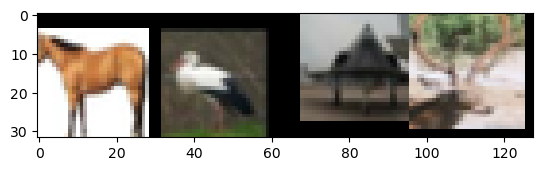

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..1.0].


Class labels:  horse bird  plane deer 


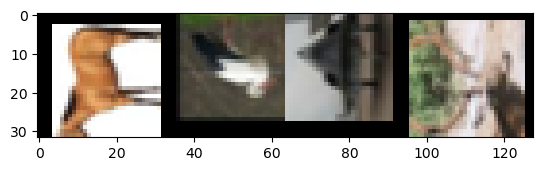

Rotation labels:  90    180   90    90   


In [3]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

# Evaluation code

In [4]:
import time

# evaluates the performance of your network.
def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)

            outputs = net(images)

            # predicted label is the one with the highest softmax score.
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # print(predicted, labels)

            # loss
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
    print('TESTING:')
    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the 10000 test images: {accuracy:.2f} %')
    # print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')
    # print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')
    
    return accuracy, avg_test_loss


In [5]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

## 1. Train a ResNet18 on the rotation task

In this section, we will train a ResNet18 model on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(num_classes=4)
net = net.to(device)

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)


In [9]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            #
            if task == 'rotation':
                images, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
                images, labels = imgs.to(device), cls_label.to(device)
            else:
                raise ValueError('task should be either "rotation" or "classification"')

            optimizer.zero_grad()

            outputs = net(images)

            outputs = outputs.to(device)

            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()
            
            predicted = torch.max(outputs.data, 1)[1]

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()


        net.eval()  # set the model to evaluation mode
        if task == 'rotation':
            print("Testing on rotation task...")
            acc, _ = run_test(net, testloader, criterion, task='rotation')
        elif task == 'classification':
            print("Testing on classification task...")
            acc, _ = run_test(net, testloader, criterion, task='classification')
            # TODO remove
            if acc >= 80.00:
                # print("Achieved 80% accuracy on classification task")
                break
        else:
            raise ValueError('task should be either "rotation" or "classification"')
        print(f'Finished epoch {epoch + 1} / {num_epochs}')
        print('-----------------------------------')
        

    print('Finished Training')

In [10]:
train(net, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.02, task='rotation')

PATH = './rotation_net_2.pth'
torch.save(net.state_dict(), PATH)
print(f'Model saved to {PATH}')


[1,   100] loss: 1.688 acc: 31.23 time: 7.94
[1,   200] loss: 1.268 acc: 41.84 time: 6.09
[1,   300] loss: 1.182 acc: 46.91 time: 6.07
Testing on rotation task...
TESTING:
Accuracy of the network on the 10000 test images: 52.89 %
Average loss on the 10000 test images: 1.082
Finished epoch 1 / 45
-----------------------------------
[2,   100] loss: 1.126 acc: 50.98 time: 7.63
[2,   200] loss: 1.098 acc: 52.56 time: 6.09
[2,   300] loss: 1.079 acc: 53.14 time: 6.06
Testing on rotation task...
TESTING:
Accuracy of the network on the 10000 test images: 54.67 %
Average loss on the 10000 test images: 1.046
Finished epoch 2 / 45
-----------------------------------
[3,   100] loss: 1.057 acc: 54.59 time: 7.57
[3,   200] loss: 1.039 acc: 55.38 time: 6.11
[3,   300] loss: 1.024 acc: 56.56 time: 6.10
Testing on rotation task...
TESTING:
Accuracy of the network on the 10000 test images: 59.00 %
Average loss on the 10000 test images: 0.975
Finished epoch 3 / 45
-----------------------------------
[

## 2.1 Fine-tuning on the pre-trained model

In this section, we will load the pre-trained ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [16]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(num_classes=4)  # we are doing 4-class classification
net.load_state_dict(torch.load(PATH, weights_only=True, map_location=device))  # load the saved weights
net = net.to(device)


In [17]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
for name, param in net.named_parameters():
    if name.startswith('layer4') or name.startswith('fc'):
        param.requires_grad = True
    else:
        param.requires_grad = False

# update the fc layer to have 10 classes
num_classes = 10
net.fc = nn.Linear(net.fc.in_features, num_classes, device=device)

In [18]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [19]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params_to_update, lr=0.01)

In [20]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

# save the fine-tuned model
FINE_TUNE_PRE_TRAIN_PATH = './fine_tuned_pre_trained_net.pth'
torch.save(net.state_dict(), FINE_TUNE_PRE_TRAIN_PATH)
print(f'Fine-tuned model saved to {FINE_TUNE_PRE_TRAIN_PATH}')

[1,   100] loss: 1.857 acc: 29.97 time: 7.36
[1,   200] loss: 1.557 acc: 41.97 time: 5.85
[1,   300] loss: 1.454 acc: 46.70 time: 5.84
Testing on classification task...
TESTING:
Accuracy of the network on the 10000 test images: 48.65 %
Average loss on the 10000 test images: 1.401
Finished epoch 1 / 20
-----------------------------------
[2,   100] loss: 1.374 acc: 50.05 time: 7.95
[2,   200] loss: 1.330 acc: 50.77 time: 5.86
[2,   300] loss: 1.329 acc: 51.96 time: 5.83
Testing on classification task...
TESTING:
Accuracy of the network on the 10000 test images: 53.04 %
Average loss on the 10000 test images: 1.292
Finished epoch 2 / 20
-----------------------------------
[3,   100] loss: 1.293 acc: 52.36 time: 7.53
[3,   200] loss: 1.312 acc: 52.32 time: 5.79
[3,   300] loss: 1.279 acc: 53.69 time: 5.78
Testing on classification task...
TESTING:
Accuracy of the network on the 10000 test images: 55.34 %
Average loss on the 10000 test images: 1.248
Finished epoch 3 / 20
-------------------

## 2.2 Fine-tuning on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [37]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
#
#
#

net = resnet18(num_classes=num_classes)  # we are doing 10-class classification
net = net.to(device)


In [38]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
# To do this, you should set requires_grad=False for the frozen layers.
#
#
#

for name, param in net.named_parameters():
    if name.startswith('layer4') or name.startswith('fc'):
        param.requires_grad = True
    else:
        param.requires_grad = False

In [39]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [24]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params_to_update, lr=0.01)

In [25]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

FINE_TUNE_RANDOM_PATH = './fine_tuned_random_net.pth'
torch.save(net.state_dict(), FINE_TUNE_RANDOM_PATH)
print(f'Fine-tuned model saved to {FINE_TUNE_RANDOM_PATH}')

[1,   100] loss: 2.261 acc: 25.13 time: 7.39
[1,   200] loss: 1.949 acc: 29.31 time: 5.84
[1,   300] loss: 1.886 acc: 31.92 time: 5.90
Testing on classification task...
TESTING:
Accuracy of the network on the 10000 test images: 36.17 %
Average loss on the 10000 test images: 1.737
Finished epoch 1 / 20
-----------------------------------
[2,   100] loss: 1.822 acc: 34.73 time: 8.01
[2,   200] loss: 1.800 acc: 35.17 time: 5.80
[2,   300] loss: 1.790 acc: 35.38 time: 5.97
Testing on classification task...
TESTING:
Accuracy of the network on the 10000 test images: 37.86 %
Average loss on the 10000 test images: 1.710
Finished epoch 2 / 20
-----------------------------------
[3,   100] loss: 1.764 acc: 36.13 time: 7.43
[3,   200] loss: 1.756 acc: 36.52 time: 5.95
[3,   300] loss: 1.758 acc: 37.05 time: 5.86
Testing on classification task...
TESTING:
Accuracy of the network on the 10000 test images: 39.90 %
Average loss on the 10000 test images: 1.664
Finished epoch 3 / 20
-------------------

## 3.1 Supervised training on the pre-trained model
In this section, we will load the pre-trained ResNet18 model and re-train the whole model on the classification task.

In [16]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model
#
#
#

PATH = './rotation_net_2.pth'
net = resnet18(num_classes=4)
net.load_state_dict(torch.load(PATH, weights_only=True, map_location=device))
net = net.to(device)

num_classes = 10
net.fc = nn.Linear(net.fc.in_features, num_classes, device=device)

In [17]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [18]:
# TODO train this again, lock it at 80%
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.0050, task='classification')

FULL_PRE_TRAINED_PATH = './full_pre_trained_net.pth'
torch.save(net.state_dict(), FULL_PRE_TRAINED_PATH)
print(f'Fine-tuned model saved to {FULL_PRE_TRAINED_PATH}')

[1,   100] loss: 1.638 acc: 38.80 time: 7.61
[1,   200] loss: 1.243 acc: 54.73 time: 6.03
[1,   300] loss: 1.142 acc: 59.26 time: 6.07
Testing on classification task...
TESTING:
Accuracy of the network on the 10000 test images: 63.87 %
Average loss on the 10000 test images: 1.029
Finished epoch 1 / 20
-----------------------------------
[2,   100] loss: 0.993 acc: 64.73 time: 7.60
[2,   200] loss: 0.952 acc: 66.80 time: 6.07
[2,   300] loss: 0.940 acc: 67.72 time: 6.04
Testing on classification task...
TESTING:
Accuracy of the network on the 10000 test images: 70.68 %
Average loss on the 10000 test images: 0.840
Finished epoch 2 / 20
-----------------------------------
[3,   100] loss: 0.865 acc: 69.78 time: 7.80
[3,   200] loss: 0.847 acc: 70.46 time: 6.10
[3,   300] loss: 0.831 acc: 71.05 time: 6.06
Testing on classification task...
TESTING:
Accuracy of the network on the 10000 test images: 72.33 %
Average loss on the 10000 test images: 0.787
Finished epoch 3 / 20
-------------------

## 3.2 Supervised training on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [14]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

num_classes = 10
net = resnet18(num_classes=num_classes)
net = net.to(device)

In [15]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [16]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.385 acc: 21.20 time: 7.62
[1,   200] loss: 1.906 acc: 30.24 time: 6.12
[1,   300] loss: 1.754 acc: 35.06 time: 6.12
Testing on classification task...
TESTING:
Accuracy of the network on the 10000 test images: 41.64 %
Average loss on the 10000 test images: 1.634
Finished epoch 1 / 20
-----------------------------------
[2,   100] loss: 1.535 acc: 43.50 time: 7.66
[2,   200] loss: 1.479 acc: 45.53 time: 6.18
[2,   300] loss: 1.381 acc: 49.78 time: 6.09
Testing on classification task...
TESTING:
Accuracy of the network on the 10000 test images: 55.48 %
Average loss on the 10000 test images: 1.230
Finished epoch 2 / 20
-----------------------------------
[3,   100] loss: 1.256 acc: 54.86 time: 7.74
[3,   200] loss: 1.193 acc: 57.02 time: 6.15
[3,   300] loss: 1.186 acc: 57.55 time: 6.16
Testing on classification task...
TESTING:
Accuracy of the network on the 10000 test images: 60.12 %
Average loss on the 10000 test images: 1.145
Finished epoch 3 / 20
-------------------

In [17]:
PATH = './full_random_net.pth'
torch.save(net.state_dict(), PATH)
print(f'Fine-tuned model saved to {PATH}')

Fine-tuned model saved to ./full_random_net.pth


In [19]:
# Advanced tasks for rotation:

lr_curve = {}

# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

import math

# also plot multiple lr curves for smaller number of epochs, figure out a good start.
def adjust_learning_rate(optimizer, epoch, init_lr, total_epochs):
    """Adjusts the learning rate using cosine annealing"""
    # if epoch < total_epochs // 2:
    #     lr = init_lr * (0.1 ** (epoch // 10))
    # else:
    lr = init_lr * 0.5 * (1 + math.cos(math.pi * epoch / total_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):
    lr_curve[init_lr] = []
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, num_epochs)

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            #
            if task == 'rotation':
                images, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
                images, labels = imgs.to(device), cls_label.to(device)
            else:
                raise ValueError('task should be either "rotation" or "classification"')

            optimizer.zero_grad()

            outputs = net(images)

            outputs = outputs.to(device)

            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()
            
            predicted = torch.max(outputs.data, 1)[1]

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()


        net.eval()  # set the model to evaluation mode
        if task == 'rotation':
            print("Testing on rotation task...")
            acc, loss = run_test(net, testloader, criterion, task='rotation')
            if acc >= 81.00:
                print(f"Accuracy of {acc:.2f} exceeds threshold of {81.00}, stopping training.")
                break
        elif task == 'classification':
            print("Testing on classification task...")
            acc, loss = run_test(net, testloader, criterion, task='classification')
        else:
            raise ValueError('task should be either "rotation" or "classification"')
        print(f'Finished epoch {epoch + 1} / {num_epochs}')
        
        lr_curve[init_lr].append((acc, loss))
        
        print('-----------------------------------')
        

    print('Finished Training')
    # return acc, loss

In [20]:
from torchvision.models import resnet50

net = resnet50(num_classes=4)  # we are doing 4-class classification
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)
train(net, criterion, optimizer, num_epochs=75, decay_epochs=10, init_lr=0.01, task='rotation')

PATH = './rotation_net_resnet50.pth'
torch.save(net.state_dict(), PATH)
print(f'Fine-tuned model saved to {PATH}')

[1,   100] loss: 2.535 acc: 25.55 time: 8.99
[1,   200] loss: 1.794 acc: 28.20 time: 7.25
[1,   300] loss: 1.607 acc: 37.36 time: 7.30
Testing on rotation task...
TESTING:
Accuracy of the network on the 10000 test images: 43.20 %
Average loss on the 10000 test images: 1.346
Finished epoch 1 / 75
-----------------------------------
[2,   100] loss: 1.261 acc: 43.64 time: 8.75
[2,   200] loss: 1.234 acc: 45.06 time: 7.22
[2,   300] loss: 1.197 acc: 46.63 time: 7.19
Testing on rotation task...
TESTING:
Accuracy of the network on the 10000 test images: 50.48 %
Average loss on the 10000 test images: 1.145
Finished epoch 2 / 75
-----------------------------------
[3,   100] loss: 1.167 acc: 47.30 time: 8.67
[3,   200] loss: 1.141 acc: 49.37 time: 7.07
[3,   300] loss: 1.149 acc: 49.01 time: 7.09
Testing on rotation task...
TESTING:
Accuracy of the network on the 10000 test images: 50.81 %
Average loss on the 10000 test images: 1.133
Finished epoch 3 / 75
-----------------------------------
[

In [20]:
PATH = './rotation_net_resnet50_new.pth'
torch.save(net.state_dict(), PATH)
print(f'Fine-tuned model saved to {PATH}')

Fine-tuned model saved to ./rotation_net_resnet50_new.pth


In [ ]:
# Advanced tasks for classification:

lr_curve = {}

# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

import math

max_acc = 0.0

# also plot multiple lr curves for smaller number of epochs, figure out a good start.
def adjust_learning_rate(optimizer, epoch, init_lr, total_epochs):
    """Adjusts the learning rate using cosine annealing"""
    # if epoch < total_epochs // 2:
    #     lr = init_lr * (0.1 ** (epoch // 10))
    # else:
    lr = init_lr * 0.5 * (1 + math.cos(math.pi * epoch / total_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):
    global max_acc
    lr_curve[init_lr] = []
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, num_epochs)

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            #
            if task == 'rotation':
                images, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
                images, labels = imgs.to(device), cls_label.to(device)
            else:
                raise ValueError('task should be either "rotation" or "classification"')

            optimizer.zero_grad()

            outputs = net(images)

            outputs = outputs.to(device)

            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()
            
            predicted = torch.max(outputs.data, 1)[1]

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()


        net.eval()  # set the model to evaluation mode
        if task == 'rotation':
            print("Testing on rotation task...")
            acc, loss = run_test(net, testloader, criterion, task='rotation')
        elif task == 'classification':
            print("Testing on classification task...")
            acc, loss = run_test(net, testloader, criterion, task='classification')
            if acc >= 84.00:
                print(f"Accuracy of {acc:.2f} exceeds threshold of {81.00}, stopping training.")
                break
            
            if acc > max_acc:
                print(f"Accuracy of {acc:.2f} exceeds previous max accuracy of {max_acc:.2f}, saving model.")
                torch.save(net.state_dict(), f'./classification_full_resnet50.pth')
                max_acc = acc
            
        else:
            raise ValueError('task should be either "rotation" or "classification"')
        print(f'Finished epoch {epoch + 1} / {num_epochs}')
        
        lr_curve[init_lr].append((acc, loss))
        
        print('-----------------------------------')
        

    print('Finished Training')
    # return acc, loss

In [ ]:
from torchvision.models import resnet50

net = resnet50(num_classes=10)
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)
train(net, criterion, optimizer, num_epochs=50, decay_epochs=10, init_lr=0.01, task='classification')

/u/kramesh/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[1,   100] loss: 4.480 acc: 11.16 time: 8.62
[1,   200] loss: 2.771 acc: 14.16 time: 7.02
[1,   300] loss: 2.281 acc: 19.25 time: 6.97
Testing on classification task...
TESTING:
Accuracy of the network on the 10000 test images: 23.91 %
Average loss on the 10000 test images: 2.073
Accuracy of 23.91 exceeds previous max accuracy of 0.00, saving model.
Finished epoch 1 / 50
-----------------------------------
[2,   100] loss: 2.080 acc: 22.47 time: 8.77
[2,   200] loss: 1.966 acc: 25.80 time: 6.97
[2,   300] loss: 1.916 acc: 27.91 time: 7.01
Testing on classification task...
TESTING:
Accuracy of the network on the 10000 test images: 32.06 %
Average loss on the 10000 test images: 1.804
Accuracy of 32.06 exceeds previous max accuracy of 23.91, saving model.
Finished epoch 2 / 50
-----------------------------------
[3,   100] loss: 1.811 acc: 32.43 time: 8.57
[3,   200] loss: 1.768 acc: 33.89 time: 7.02
[3,   300] loss: 1.720 acc: 35.92 time: 6.97
Testing on classification task...
TESTING:
A